# Run a Pre-Trained RoBERTa Model to Classify Tweets into Policy Areas

We'll be using XLM-RoBERTa Models finetuned on Comparative Agendas Project Data to classify our Data

Models were introduced in this paper: https://doi.org/10.1177/08944393241259434

And are part of the CAP Babel Machine: https://capbabel.poltextlab.com/

In [1]:
import pandas as pd
import numpy as np
import torch
import re
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [2]:
# device setup
if torch.cuda.is_available(): # CUDA is the preferred device
    device = 'cuda:0'
    print(f'Cuda Found. Running on {torch.cuda.get_device_name(0)}')
else: 
    if torch.backends.mps.is_available(): # MPS backend for Mac
        device = 'mps'
        print('MPS Found. Running on MPS')
    else: 
        device = 'cpu' # fallback to CPU computing
        print('No GPU Found. Running on CPU')

Cuda Found. Running on NVIDIA GeForce GTX 1060 6GB


### Read in data, merge categories and drop uncoded entries

In [3]:
# read data
data = pd.read_csv("CAP_sample_coded.tsv", 
                   sep="\t", 
                     dtype={"_id": str} # _id column as string to avoid scientific notation
                     )

# we remove the categories "wirtschaft" (economy) and "haushalt_finanzen" (finance) in favor of the compound category "wirtschaft_finanzen"
data = data.drop(columns=["wirtschaft", "haushalt_finanzen"])
# rename "wirtschaft_finanzen_merge" to "wirtschaft_finanzen"
data = data.rename(columns={"wirtschaft_finanzen_merge": "wirtschaft_finanzen"})

# pivot data to long format
data_long = data.melt(id_vars=["_id", "intercoder_sample", "coder", "_source.text"], 
                      var_name="label")

data_long = data_long[data_long.value == True] # only keep tweets labeled as a certain category (drop False values)

# remove value and coder column
data_long = data_long.drop(columns=["value", "coder"])

data_long

,_id,intercoder_sample,_source.text,label
802,1623756907532910593,False,Das #Deutschlandticket ist ein richtiger Schri...,verkehr
806,1400799340021616640,False,Das Jobticket ist nun seit einem Monat am Star...,verkehr
825,1044258236663304193,False,Der Antrag zu einem Sozialticket für Bus und B...,verkehr
853,1483489042691940357,False,Die Stadt Leverkusen inkl. Oberbürgermeister u...,verkehr
866,1109875138516959234,False,Diese Kampagne bringt wohl mehr als die üblich...,verkehr
...,...,...,...,...
40770,1360263802294579201,True,Der #Unternehmerlohn für Kulturschaffende und ...,wirtschaft_finanzen
40774,1457645827078434818,True,"Schätzungen gehen davon aus, dass jedes Jahr m...",wirtschaft_finanzen
40778,1522118401937793033,True,Eil: Gericht erklärt #Wirecard-Bilanzen für ni...,wirtschaft_finanzen
40779,1567473763280719872,True,"Fraktionsvize @mueller_sepp stellt fest, für O...",wirtschaft_finanzen


In [4]:
# nr of unique documents that are labeled. Note: not all document in the data had been labeled, hence the reduced number!
data_long._id.nunique()

597

In [5]:
# get duplicated rows by _id (i.e. documents fitting multiple labels)
multi_label = data_long[data_long.duplicated('_id', keep = False)]
multi_label._id.nunique() # 181 out of 597 documents have more than one label

181

### Prepare Dictionaries to translate transformer output, CAP categories and EPINetz coding

In [6]:
CAP_NUM_DICT = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', # translates Model Output to CAP Major Policy Codes
6: '7', 7: '8', 8: '9', 9: '10', 10: '12', 11: '13', 12: '14', 
13: '15', 14: '16', 15: '17', 16: '18', 17: '19', 18: '20', 19: 
'21', 20: '23', 21: '999'}

num_labels = len(CAP_NUM_DICT)

NOTE: The EPINetz Coding partly consists of compound categories uniting several sub-categories of the CAP Codebook (e.g. 1901 adn 1905 for "entwicklung" (developmental aid/cooperation) or 609, 1526 and 1707 for "kultur_medien_sport" (culture, media, sports)). However, the classifier only codes the major categories of the CAP (6, 15, 17, 19...). 


This means that we can 

a) only roughly recreate the EPINetz coding, as the minor categories are not coded

b) the output for compound categories overlapping two or more major categories can be very unreliable


Also note that the classifier's labels only got up to category 23, factually dropping categories 24 (State and Local Government Administration) and 25 (German Reunification). These were used in the EPINetz coding scheme for innere_sicherheit (domestic policy and security) (24) and gesellschaft (social issues) (25). These are dropped in the dictionary below.

Additionally, the classifier (and the english CAP) contain category 23 (culture) not present in the German CAP/EPINetz codings. As the "kultur_medien_sport" category is dropped with its original codings, we can replace it with category 23. NOTE: when evaluating the results for this label, be aware that the coding schemes differ! This is done only to see potential overlap between the original EPINetz category and the automated "culture" coding.

See below for compound categories.

In [7]:
epinetz_dict = {
'verkehr':['10'], 
# 'entwicklung':[19], # falls into foreign policy for the classifier
'gesellschaft':['2'], 
'innere_sicherheit':['12','20'],
'verteidigung':['16'], 
'aeusseres':['18','19'], 
'digitalisierung_technik':['17'], 
'soziales':['12','13','14'],
'umwelt':['7','21'], 
# 'europa':['19'], # falls into foreign policy for the classifier
'arbeit':['5','9'], 
# 'kultur_medien_sport':['6','15','17'], # this cannot be sufficiently distinguished from other categories due to major topic overlap
'kultur_medien_sport':['23'], # add the "culture" category from the english CAP (not present in the german CAP) instead. Consider results carefully!
'gesundheit':['3'],
'landwirtschaft_ernaehrung':['4'], 
'bildung_forschung':['6'], 
'wirtschaft_finanzen':['1','8','15'],
'none':['999'],
}

Effectively, this makes the EPINetz categories "entwicklung" (developmental aid/cooperation), "auesseres" (foreign policy), and "europa" (european policy) one and the same for the classifier (CAP category 19: foreign affairs), losing all nuance between these three sub-topics. Furthermore, "kultur_medien_sport" overlaps with "digitalisierung_technik", "wirtschaft_finanzen" and "bildung_forschung", effectively dissolving it in the classification process.

NOTE: Major Policy Category 9 does not exist in the German CAP coding scheme, but is part of "Labor, Employment and Immigration" (5)

### Tests

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("poltextlab/xlm-roberta-large-german-cap-v3")

model.config.id2label = CAP_NUM_DICT # replace the labels with the CAP Major Policy Codes
model.config.label2id = {value: key for key, value in CAP_NUM_DICT.items()} # same for the label2id (reversing the dictionary)

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

c:\ProgramData\miniconda3\envs\gesis_nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
example = data_long["_source.text"].iloc[100]

inputs = tokenizer(example,
                   return_tensors="pt",
                   max_length=512,
                   padding="do_not_pad",
                   truncation=True
                   )

logits = model(**inputs).logits

probs = torch.softmax(logits, dim=1).tolist()[0]
probs = {model.config.id2label[index]: round(probability, 2) for index, probability in enumerate(probs)}
top3_probs = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:3])

print(example)

print(top3_probs)

Was erleben die Teilnehmenden im Programm Berufsorientierung für Flüchtlinge – #BOF? Eine Gruppe junger Geflüchteter, die bei der Kreishandwerkerschaft Hersfeld-Rotenburg im Frühjahr und Sommer 2018 am Programm teilgenommen hat, erzählt: https://t.co/mjX0ldC1bJ https://t.co/OzXP8BnhMJ
{'9': 0.64, '5': 0.19, '13': 0.07}


In [10]:
#replace keys in top3_probs with keys from epinetz_dict
test_df = pd.DataFrame(top3_probs, index=[0]).melt(var_name="label", value_name="probability")

test_df['epinetz_label'] = test_df['label'].map({v: k for k, values in epinetz_dict.items() for v in values})

test_df

,label,probability,epinetz_label
0,9,0.64,arbeit
1,5,0.19,arbeit
2,13,0.07,soziales


In [11]:
# only get the highest probability for each epinetz_label
test_df.groupby("epinetz_label")["probability"].max()

epinetz_label
arbeit      0.64
soziales    0.07
Name: probability, dtype: float64

In [12]:
# sum probabilities of the same epinetz_label
test_df.groupby("epinetz_label")["probability"].sum()

epinetz_label
arbeit      0.83
soziales    0.07
Name: probability, dtype: float64

In [13]:
from transformers import pipeline

classifier = pipeline(task='text-classification', # make classifier pipeline
                      device=device,
                      model=model, 
                      tokenizer = tokenizer, 
                      top_k=None) # return scores for all labels

In [14]:
classifier(example, batch_size=32) 
# note that the returned probabilities differ slightly from the classification above - possibly due to a different softmax function

[[{'label': '9', 'score': 0.4536440074443817},
  {'label': '5', 'score': 0.19488398730754852},
  {'label': '13', 'score': 0.07830250263214111},
  {'label': '2', 'score': 0.042280878871679306},
  {'label': '6', 'score': 0.02598363161087036},
  {'label': '12', 'score': 0.010741520673036575},
  {'label': '16', 'score': 0.01043943502008915},
  {'label': '1', 'score': 0.009801131673157215},
  {'label': '20', 'score': 0.007032905705273151},
  {'label': '23', 'score': 0.005228388123214245},
  {'label': '15', 'score': 0.005092584528028965},
  {'label': '19', 'score': 0.004952979739755392},
  {'label': '14', 'score': 0.004859070759266615},
  {'label': '3', 'score': 0.00278540444560349},
  {'label': '4', 'score': 0.0019994177855551243},
  {'label': '21', 'score': 0.0019581534434109926},
  {'label': '18', 'score': 0.0019207140430808067},
  {'label': '8', 'score': 0.0016826213104650378},
  {'label': '17', 'score': 0.0016363554168492556},
  {'label': '10', 'score': 0.0015441903378814459},
  {'label

### Reusable Functions for Data Wrangling, Model Setup, and Visualization

In [54]:
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid") # plot style

def run_classification(data, model_name, tokenizer_name):
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    model.config.id2label = CAP_NUM_DICT # replace the labels with the CAP Major Policy Codes
    model.config.label2id = {value: key for key, value in CAP_NUM_DICT.items()} # same for the label2id (reversing the dictionary)

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    classifier = pipeline(task='text-classification', # make classifier pipeline
                      device=device,
                      model=model, 
                      tokenizer = tokenizer, 
                      top_k=None) # return scores for all labels
    
    pred = classifier(list(data["_source.text"]), batch_size=32)
    
    # add predictions to the data
    data["pred"] = pred

    # unnest the data
    data = data.explode("pred")

    data['pred_label'] = data['pred'].apply(lambda x: x['label'])
    data['pred_score'] = data['pred'].apply(lambda x: x['score'])

    data = data.drop(columns=['pred'])
    
    # add EPINetz labels
    data['pred_epinetz'] = data['pred_label'].map({v: k for k, values in epinetz_dict.items() for v in values}) 
    
    # replace ground truth labels "entwicklung" and "europa" with "aeusseres" (as per coding scheme adjustments above)
    data['label'] = data['label'].replace({'entwicklung':'aeusseres', 'europa':'aeusseres'})

    data = data.drop_duplicates(subset=['_id','label', 'pred_epinetz']) # drop the duplicates introduced by the label adjustments (multiple "aeusseres" labels on one document)
    
    # sum probabilities of the same epinetz_label (that is, for the different CAP categories making up some of the EPINetz categories)
    data['pred_score_sum'] = data.groupby(['_id','label','pred_epinetz'])['pred_score'].transform('sum')

    print(f'{data._id.nunique()} unique documents classified.') # double check we did not lose any documents in the wrangling

    return data

def get_boxplot(data):
    # for each _id, get the rows where label and pred_epinetz are equal, then visualize the pred_score_sum
    data_vis = data[data['label'] == data['pred_epinetz']]

    boxplot = sns.boxplot(data=data_vis, 
                        y ='pred_score_sum', 
                        x = 'label',
                        fill=True)

    boxplot.tick_params(axis='x', rotation=90)

def get_heatmap(data):
    # make a heatmap for the overlap between the ground truth and the predicted labels
    data_heat = data.groupby(['label', 'pred_epinetz'])['pred_score'].median().reset_index().pivot(index='label', columns='pred_epinetz', values='pred_score').fillna(0)

    sns.heatmap(data_heat, annot=False, fmt=".2f", cmap="rocket_r")

## General German CAP Model

https://huggingface.co/poltextlab/xlm-roberta-large-german-cap-v3

In [58]:
cap_general = run_classification(data_long, "poltextlab/xlm-roberta-large-german-cap-v3", "xlm-roberta-large")

c:\ProgramData\miniconda3\envs\gesis_nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


597 unique documents classified.


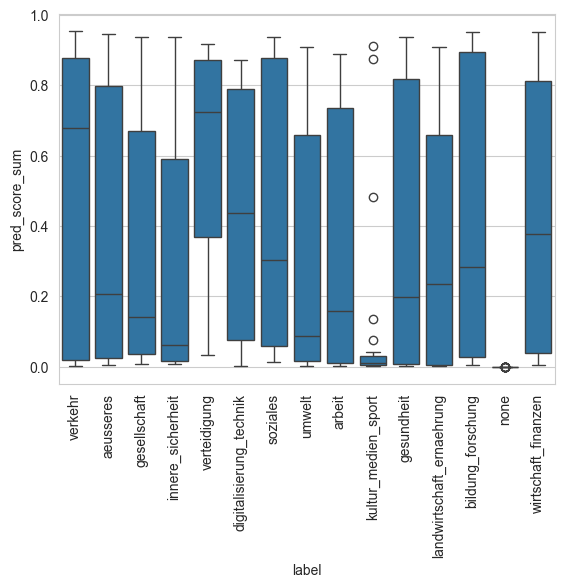

In [46]:
get_boxplot(cap_general)

This does not look good. Only for "verkehr" (Transportation Policy) and "verteidigung" (Defense) we have a median above 0.6. The majority of EPINetz categories has a median below 0.5 - that is, a coin toss would do better in classifying the documents into these categories. The "culture" category replaced by the CAP coding in the model is especially bad, but this was to be expected.

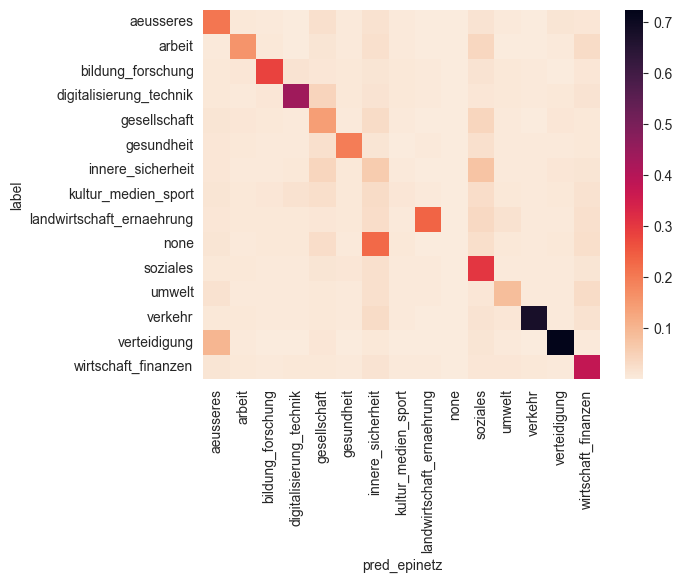

In [47]:
get_heatmap(cap_general)

This heatmap shows the median prediction score for each label pair, revealing likely misclassifications. The Defense/Foreign Policy overlap was to be expected (that is, the model may classify a defense document as foreign policy). However, it is also more likely to consider documents with no policy topic as domestic policy, and is more likely to do so than correctly classifying domestic policy documents.

## German CAP Model trained on Media Data

https://huggingface.co/poltextlab/xlm-roberta-large-german-media-cap-v3

Maybe this will do better in classifying the documents, which are politicians' tweets?

In [59]:
cap_media = run_classification(data_long, "poltextlab/xlm-roberta-large-german-media-cap-v3", "xlm-roberta-large")

c:\ProgramData\miniconda3\envs\gesis_nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


597 unique documents classified.


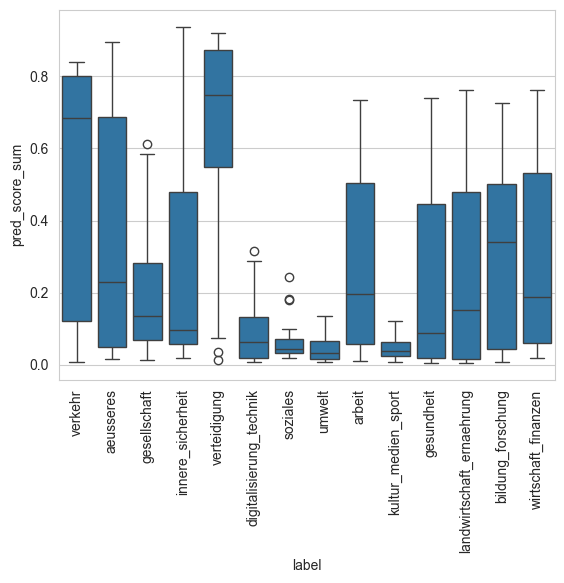

In [50]:
get_boxplot(cap_media)

This model performs even worse. Again, only transportation and defence are halfway decent. A lot of categorizations are complete misses.

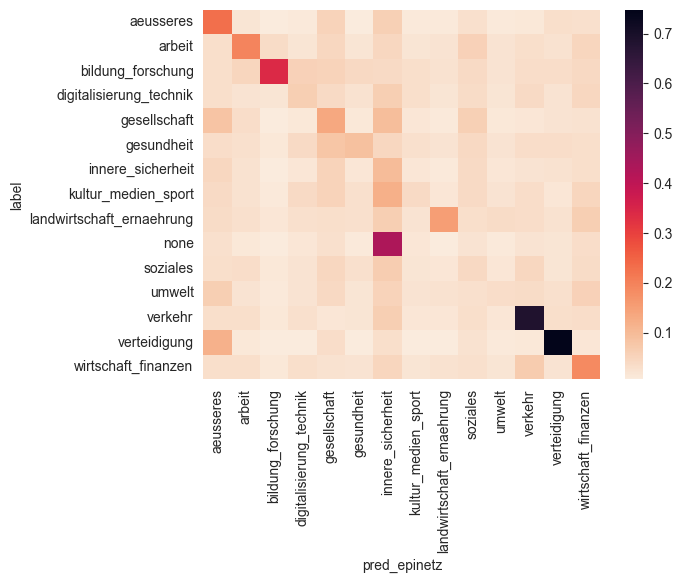

In [52]:
get_heatmap(cap_media)

This model is even more confused. It is not only bad at predicting the correct category, it also has a higher tendency to predict a wrong category instead.

## German CAP Model trained on Party Data

https://huggingface.co/poltextlab/xlm-roberta-large-german-party-cap-v3

Help us, RoBERTa model trained on party data, you are our only hope. After all, we're dealing with politicians' tweets here, and they're in parties, right?

In [55]:
cap_party = run_classification(data_long, "poltextlab/xlm-roberta-large-german-party-cap-v3", "xlm-roberta-large")

c:\ProgramData\miniconda3\envs\gesis_nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


597 unique documents classified.


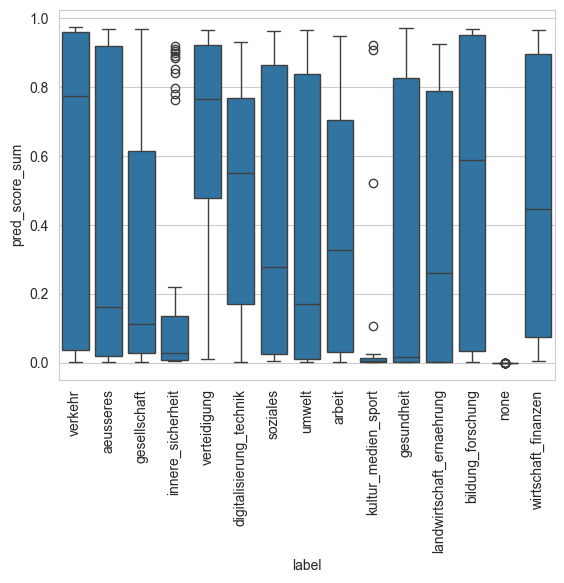

In [56]:
get_boxplot(cap_party)

This is better than the media model, and in some categories, we even see some improvements over the general model (Transportation, Digitalisation & Technology, Labor, Environment, Economy; big improvement on Education & Research). However, the other categories perform worse, in some cases even significantly so (e.g Domestic Policy, and especially Health). The "culture" category remains useless (due to differences in coding, see above).

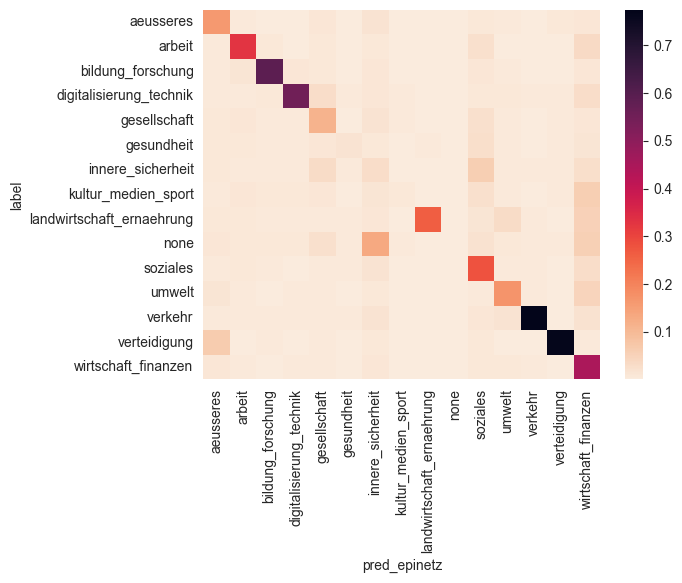

In [57]:
get_heatmap(cap_party)

Here we can see how the confusion of categories also becomes less likely, and some categories now perform quite well. However, we can also see that some perform worse - especially Health, for which this model is basically useless.

## Conclusion

Considering the results, it would be sensible to start with the party-tuned model and fine tune on additional, EPINetz-labeled data, especially on documents concerning health policy. However, we currently do not possess a sufficient number of labeled documents.